### Basic Setup

In [47]:
!pip install "dask[dataframe]"

In [48]:
import dask.dataframe as dd

# Replace the path with the actual path to your large CSV file
ddf = dd.read_csv('C:/Users/heyri/OneDrive/Desktop/transactions.csv')

In [49]:
ddf.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt
0,170626010790603097,6/26/2017,1079,60002999245170,20297499,4.49,1,0.00
1,170626010790603036,6/26/2017,1079,1130090056,20582836,11.99,1,0.00
2,170626010790603036,6/26/2017,1079,1130090056,20772015,12.00,1,0.00
3,170626010790603105,6/26/2017,1079,1020078162,20323904,0.57,1,0.01
4,170626010790603120,6/26/2017,1079,1143680672,20996145,2.06,1,0.09


### Data Pre-cleaning

In [50]:
from datetime import datetime

# Remove closed stores
closed_stores = [8540]
ddf = ddf[~ddf['store_id'].isin(closed_stores)]

# Remove transactions after COVID-19
ddf['trans_dt'] = dd.to_datetime(ddf['trans_dt'])
# Define the cutoff date
cutoff_date = datetime(2020, 2, 1)
# Filter the DataFrame to keep only transactions before the cutoff date
ddf_filtered = ddf[ddf['trans_dt'] < cutoff_date]

### Sampling

In [51]:
# Assuming ddf is your Dask DataFrame
unique_customers = ddf_filtered[['cust_id']].drop_duplicates().compute()

In [52]:
len(unique_customers)

8096538

In [53]:
import numpy as np

# Step 2: Generate a random sequence of indexes
random_indices = np.random.permutation(len(unique_customers))

# Step 3: Assign these random indices to unique_customers
unique_customers['random_index'] = random_indices

# Now, each customer ID has a unique random index assigned

In [63]:
# Step 4: Sample 5% random indices
sample_size = int(0.05 * len(unique_customers))  # Adjust the sample size as 5%
sampled_indices = np.random.choice(unique_customers['random_index'], size=sample_size, replace=False)

# Step 5: Select the customer IDs corresponding to these sampled indices
sampled_customer_ids = unique_customers[unique_customers['random_index'].isin(sampled_indices)]['cust_id']

In [64]:
# Step 6: Filter the original Dask DataFrame
sampled_ddf = ddf_filtered[ddf_filtered['cust_id'].isin(sampled_customer_ids.values)]

# Depending on your needs, you might want to compute the result or keep it as a Dask DataFrame for further processing
sampled_ddf_computed = sampled_ddf.compute()

In [68]:
sampled_ddf_computed

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt
11,170626010790603094,2017-06-26,1079,1129468649,20863017,6.99,1,0.0
13,170626010790603067,2017-06-26,1079,1048060135,20425475,12.09,1,0.0
22,170626010790603073,2017-06-26,1079,1018749739,20842545,4.49,1,0.0
25,170626010790603073,2017-06-26,1079,1018749739,20293336007,1.94,1,0.0
33,170626010790603050,2017-06-26,1079,1092380896,20664782003,5.99,1,0.0
...,...,...,...,...,...,...,...,...
843611,170624010010100011,2017-06-24,1001,1131542435,20782985,5.98,2,0.0
862395,170624011790307533,2017-06-24,1179,60002550612870,20625055,7.00,2,0.0
862520,170624011790603516,2017-06-24,1179,1134294979,20161161001,6.58,2,0.0
862889,170624011880308498,2017-06-24,1188,1124432390,20312527001,5.00,2,0.0


In [69]:
# Count the number of unique stores
unique_stores = sampled_ddf_computed['store_id'].unique()

# Count the number of unique stores
num_unique_stores = sampled_ddf_computed['store_id'].nunique()

# Display the result
print("Number of unique stores: ", num_unique_stores)
print("Store list: ", unique_stores)

## The closed store: 8540, The store opened during COVID: 1424

Number of unique stores:  58
Store list:  [1079 1082 1016 1021 1032 1010 1004 1127 1154 1200 1212 1001 1066 1000
 1051 1005 1007 1095 1003 1023 1028 1099 1011 1014 1019 1027 1029 1083
 1064 1022 1155 1035 1170 1179 1188 1194 1174 1114 1090 1092 1020 1040
 1208 1050 1132 1142 1231 1222 1213 1220 1210 1214 1211 1217 1221 1223
 1227 5264]


### Join Products table

In [70]:
import pandas as pd

# Assuming 'sampled_ddf_computed' is your sampled DataFrame already in pandas format
# Load the product details DataFrame
products_df = pd.read_csv("C:/Users/heyri/OneDrive/Desktop/products.csv")

In [71]:
products_df.head(10)

,prod_id,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,20000002.0,ACSE SS TUNA LT CHUNK IN BROTH,Grocery,Canned,Canned Fish/Meat,Canned Tuna,ACSE,1.0,KG,1.88
1,20000005.0,ACSE APPLE CIDER 3 LT,Produce,Hard Goods,Dressing/Dips/Juices,Juice,ACSE,1.0,L,3.00
2,20000069.0,ACSE WHOLE COD,Seafood,Fresh Seafood,Fresh Fish,Cod,ACSE,1.0,KG,1.00
3,20000086.0,S.S. SR. JUICE BERRIES,Bulk,Bulk Foods,Confectionary,Candy,SANB,1.0,UN,1.00
4,20000093.0,DANONE ACTIVIA CLUB PACK,Dairy,Yogurt/Refrigerated Juice,Yogurt,Health,DACT,24.0,G,100.00
5,20000100.0,DION CHILIES MEXICAN GROUND,Grocery,Baking,Baking-Spices,Core Spice,DION,1.0,G,39.00
6,20000109.0,FOL GREETING CARDS 3.5X5 (12),Entertainment,Photo Image,Off-Site,Off-site,FUJI,1.0,EA,1.00
7,20000123.0,HUMO SANTO DOMINICAN ROBUSTO,Tobacco,Tobacco,Cigars,Full Size Cigars,HUMO,1.0,EA,1.00
8,20000128.0,VILEDA REFILL FIBROCONTACT,Grocery,Household Cleaning Needs,Brushes & Brooms-Hou,Refills,VLDA,1.0,EA,1.00
9,20000141.0,PRICE PRINT,Entertainment,Photo Image,Rollwork,NaN,UNGM,1.0,EA,1.00


In [73]:
# Perform the join
joined_df = sampled_ddf_computed.merge(products_df, on='prod_id', how='left')

In [75]:
joined_df.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170626010790603094,2017-06-26,1079,1129468649,20863017,6.99,1,0.0,YVES FALAFEL BALLS,Deli,Gourmet Foods,Gourmet Foods,Meat Alternatives,YVES,1.0,G,240.0
1,170626010790603067,2017-06-26,1079,1048060135,20425475,12.09,1,0.0,ACSE LEMON AND LIME JUICER,Home,Kitchen Prep,Kitchen Gadgets,Baking & Cooking,ACSE,1.0,EA,1.0
2,170626010790603073,2017-06-26,1079,1018749739,20842545,4.49,1,0.0,FROSTED FLAKES CEREAL,Grocery,Breakfast,Cereal Rte,Adult,KLGS,1.0,G,425.0
3,170626010790603073,2017-06-26,1079,1018749739,20293336007,1.94,1,0.0,GM NANTUCKET MED ROAST KCUP,Grocery,Hot Beverages & Accessories,Coffee,Single Cup,KRIG,1.0,EA,12.0
4,170626010790603050,2017-06-26,1079,1092380896,20664782003,5.99,1,0.0,PERRIER SLIM CANS LIME,Grocery,Cold Beverages,Water,Carbonated Flavor,PERI,10.0,ML,250.0


In [77]:
# Correct way to access the shape of a DataFrame
print(joined_df.shape)

(45153798, 17)


### Simple EDA

In [88]:
# Select only prod_id and prod_desc from products_df
product_descriptions = products_df[['prod_id', 'prod_desc', 'prod_category', 'prod_subcategory', 'prod_type']]

# Sum of sales_amt by product_id to see revenue distribution
revenue_distribution = joined_df.groupby('prod_id')['sales_amt'].sum().reset_index()

# Count of transactions by product_id to see volume distribution
volume_distribution = joined_df.groupby('prod_id').size().reset_index(name='transaction_count')

# Merge revenue distribution with product descriptions
revenue_distribution_with_desc = pd.merge(revenue_distribution, product_descriptions, on='prod_id', how='left')

# Merge volume distribution with product descriptions
volume_distribution_with_desc = pd.merge(volume_distribution, product_descriptions, on='prod_id', how='left')

# Sort by revenue for analysis, now including product description
revenue_sorted_with_desc = revenue_distribution_with_desc.sort_values(by=['sales_amt'], ascending=False)

# Sort by transaction count for analysis, now including product description
volume_sorted_with_desc = volume_distribution_with_desc.sort_values(by=['transaction_count'], ascending=False)

In [99]:
revenue_sorted_with_desc.head(50)

,prod_id,sales_amt,prod_desc,prod_category,prod_subcategory,prod_type
20766,20733932,6400197.44,PHARMACY RX,Dispensing,Dispensing,NaN
1248,20027156,1072253.75,ELEC. LOTTERY,Lottery - Electronic,LOTTERY - ELECTRONIC,Electronic
86017,20175355001,1053041.11,BANANA,Fruit,Bananas,Yellow
62244,21087193,775439.74,ACSE CHKN BRST BNLS SKNLS CP LSL,Fresh-Poultry,Fresh-Poultry,Breasts
93901,20425775001,757439.68,GRAPE GREEN SEEDLESS,Fruit,Grapes,Green Grapes
9189,20252014,755668.41,ACSE BBQ CHICKEN 900G,HMR,Ready to Eat,Whole Rotisserie Chicken
15517,20600985,673252.28,ACSE DELALLO OLIVES AND ANTIPASTO,Gourmet Foods,Gourmet Foods,Olives
24379,20794110,641890.79,ACSE WHOLE BEEF TENDERLOIN,Fresh Beef,Fresh-Beef,AAA
85749,20159199001,641746.27,GRAPE RED SEEDLESS,Fruit,Grapes,Red Grapes
26278,20821992,619718.13,ACSE FF CHKN BRST BNLS SKNLS CP,Fresh-Poultry,Fresh-Poultry,Breasts


In [100]:
volume_sorted_with_desc.head(50)

,prod_id,transaction_count,prod_desc,prod_category,prod_subcategory,prod_type
8813,20189092,1675172,ACSE PLASTIC BAGS,Household,Front End Bags,Front End Bags
86017,20175355001,713751,BANANA,Fruit,Bananas,Yellow
17741,20668578,232085,PENNY ROUNDING - DO NOT TOUCH,Coupons,BASKET COUPONS,NaN
84417,20070132001,213286,CUCUMBER ENGLISH,Vegetables,Field Veg,Seedless
98452,20812144001,181083,"ACSE GRADE A EGGS LARGE WHITE, EA",Milk & Eggs,Eggs,Core
83531,20007535001,154689,PEPPERS RED SWEET,Vegetables,Peppers,Red Peppers
85526,20145621001,154662,BROCCOLI,Vegetables,Cooking Veg,Broccoli
102754,21097012001,151337,AVOCADO BULK,Fruit,Tropical,Avocado
18026,20671789,148032,ACSE PLUS POINTS,Coupons,BASKET COUPONS,NaN
83820,20028593001,147269,LEMON,Fruit,Citrus,Lemons


In [91]:
# Counting Unique Values
# Assuming products_df is your DataFrame and has columns like 'prod_id', 'prod_section', 'prod_category', 'prod_subcategory', 'prod_type'

unique_products = joined_df['prod_id'].nunique()
unique_sections = joined_df['prod_section'].nunique()
unique_categories = joined_df['prod_category'].nunique()
unique_subcategories = joined_df['prod_subcategory'].nunique()
unique_types = joined_df['prod_type'].nunique()

print(f"Unique Products: {unique_products}")
print(f"Unique Sections: {unique_sections}")
print(f"Unique Categories: {unique_categories}")
print(f"Unique Subcategories: {unique_subcategories}")
print(f"Unique Types: {unique_types}")


Unique Products: 103540
Unique Sections: 32
Unique Categories: 100
Unique Subcategories: 411
Unique Types: 1918


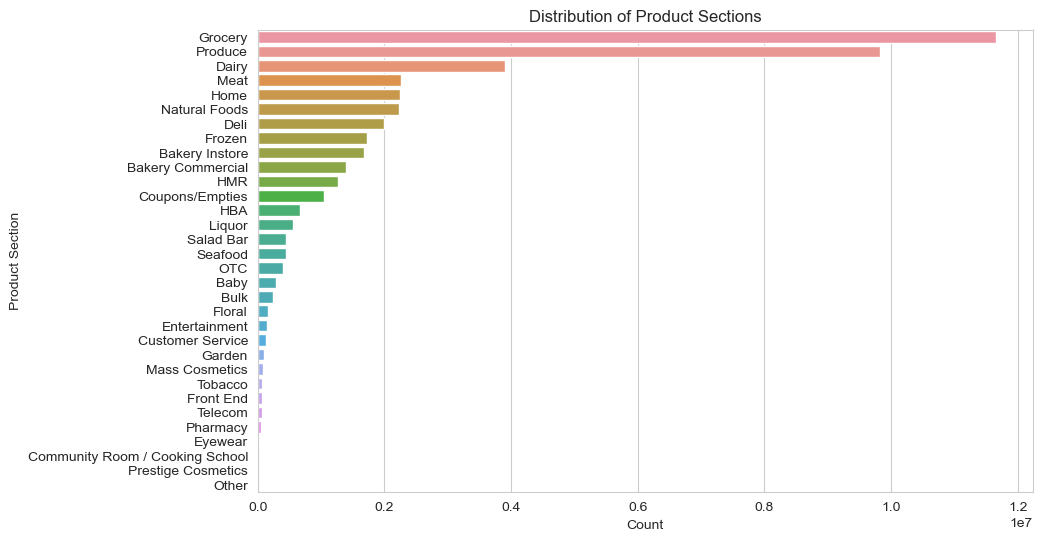

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of prod_section sorted by count
plt.figure(figsize=(10, 6))
section_order = joined_df['prod_section'].value_counts().index  # Sort sections by count
sns.countplot(data=joined_df, y='prod_section', order=section_order)
plt.title('Distribution of Product Sections')
plt.xlabel('Count')
plt.ylabel('Product Section')
plt.show()

In [98]:
# Step 1: Group by 'prod_section' and sum 'sales_amt'
section_sales = joined_df.groupby('prod_section')['sales_amt'].sum().reset_index()

# Step 2: Calculate the total sales amount
total_sales = section_sales['sales_amt'].sum()

# Step 3: Calculate the percentage of total sales for each section
section_sales['percent_of_total'] = (section_sales['sales_amt'] / total_sales) * 100

# Display the result
print(section_sales[['prod_section', 'percent_of_total']].sort_values(by='percent_of_total', ascending=False))

                       prod_section  percent_of_total
15                          Grocery         21.549306
27                          Produce         15.717177
21                             Meat         10.296513
7                             Dairy          7.462792
22                    Natural Foods          5.990618
8                              Deli          5.719861
17                              HMR          3.577039
13                           Frozen          3.513555
2                    Bakery Instore          3.223071
25                         Pharmacy          2.682979
29                          Seafood          2.202755
19                           Liquor          2.047865
1                 Bakery Commercial          1.968020
18                             Home          1.934094
16                              HBA          1.814317
23                              OTC          1.784408
30                          Telecom          1.444707
28                        Sa

### Data Cleaning

In [ ]:
# Drop non-products (e.g., service fees, donations, bottle returns, plastic bags, etc.)
# Drop customers with less than 0 sales_amt, sales_qty, and sales_weight.
# Drop transaction duplicates, meaning those rows have the same trans_id and prod_id.
